# 🏀 WNBA 2025 Player Performance Analysis 🏀
## Author: Mindy Cruz
## Date: 12/4/2025

This notebook analyzes 2025 WNBA player box score data from theSportsDataverse WeHoop repository to explore performance trends and predict player scoring outcomes.

In [1]:
# Import Libraries

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
#style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8,5)

In [3]:
#Data
data_path = "../data/player_box_2025_update.csv"
print(os.path.exists(data_path))  # Should print True

df = pd.read_csv(data_path)
print("Initial Data Shape:", df.shape)
df.head()

True
Initial Data Shape: (7140, 25)


,game_date,athlete_display_name,team_name,minutes,field_goals_made,field_goals_attempted,three_point_field_goals_made,three_point_field_goals_attempted,free_throws_made,free_throws_attempted,...,blocks,turnovers,fouls,plus_minus,points,starter,ejected,did_not_play,home_away,team_winner
0,10/10/2025,NaLyssa Smith,Aces,23.0,2,4,0,0,1.0,2,...,0,2,4,16,5.0,True,False,False,away,True
1,10/10/2025,Kierstan Bell,Aces,7.0,1,1,1,1,0.0,0,...,0,0,0,-1,3.0,True,False,False,away,True
2,10/10/2025,A'ja Wilson,Aces,36.0,7,21,0,2,17.0,19,...,3,2,3,3,31.0,True,False,False,away,True
3,10/10/2025,Chelsea Gray,Aces,38.0,6,15,4,9,2.0,4,...,2,0,2,9,18.0,True,False,False,away,True
4,10/10/2025,Jackie Young,Aces,35.0,5,14,1,6,7.0,8,...,0,2,0,1,18.0,True,False,False,away,True


In [4]:
# ----------------------------
# Data Cleaning and Prep
# ----------------------------

cols_to_keep = [
    "athlete_display_name",
    "team_name",
    "game_date",
    "minutes",
    "points",
    "rebounds",
    "assists",
    "steals",
    "blocks",
    "turnovers",
    "field_goals_made",
    "field_goals_attempted",
    "three_point_field_goals_made",
    "three_point_field_goals_attempted",
    "free_throws_made",
    "free_throws_attempted",
    "team_winner",
    "home_away"
]

df = df[cols_to_keep].copy()

# ----------------------------
# Convert data types
# ----------------------------
df['game_date'] = pd.to_datetime(df['game_date'], errors='coerce')

numeric_cols = [
    "minutes", "points", "rebounds", "assists", "steals",
    "blocks", "turnovers",
    "field_goals_made", "field_goals_attempted",
    "three_point_field_goals_made", "three_point_field_goals_attempted",
    "free_throws_made", "free_throws_attempted"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# ----------------------------
# Create shooting percentages
# ----------------------------
df["fg_pct"] = df["field_goals_made"] / df["field_goals_attempted"]
df["three_pt_pct"] = df["three_point_field_goals_made"] / df["three_point_field_goals_attempted"]
df["ft_pct"] = df["free_throws_made"] / df["free_throws_attempted"]

df[["fg_pct", "three_pt_pct", "ft_pct"]] = df[["fg_pct", "three_pt_pct", "ft_pct"]].replace([np.inf, -np.inf], np.nan)

# ----------------------------
# Handle missing shooting percentage values
# ----------------------------
for col in ["fg_pct", "three_pt_pct", "ft_pct"]:
    df[col] = df.groupby("athlete_display_name")[col].transform(lambda x: x.fillna(x.mean()))
    df[col] = df[col].fillna(0)

# ----------------------------
# Drop duplicates
# ----------------------------
df = df.drop_duplicates()

print("Cleaned Data Shape:", df.shape)
df.info()


Cleaned Data Shape: (7140, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140 entries, 0 to 7139
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   athlete_display_name               7140 non-null   object        
 1   team_name                          7140 non-null   object        
 2   game_date                          7140 non-null   datetime64[ns]
 3   minutes                            7135 non-null   float64       
 4   points                             7138 non-null   float64       
 5   rebounds                           7140 non-null   int64         
 6   assists                            7140 non-null   int64         
 7   steals                             7140 non-null   int64         
 8   blocks                             7140 non-null   int64         
 9   turnovers                          7140 non-null   int64         
 10  field

Number of games with 0 minutes: 1266
Percentage of games with 0 minutes: 17.73%


<Figure size 1800x500 with 0 Axes>

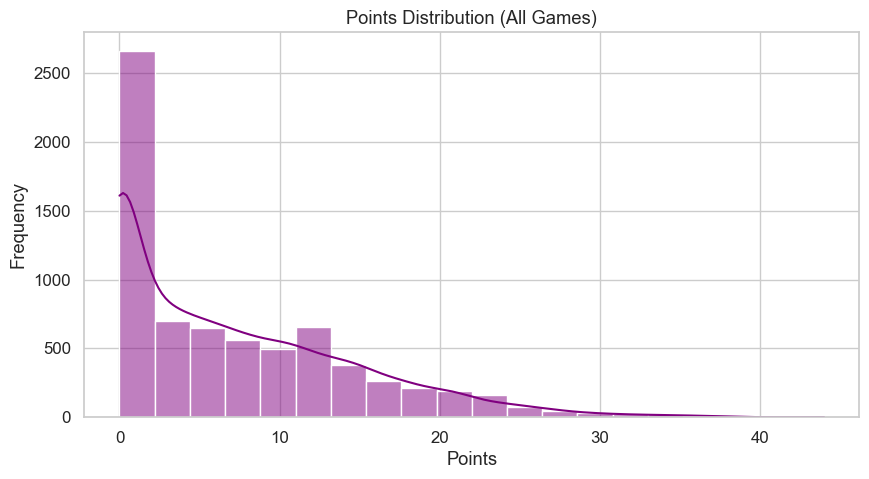

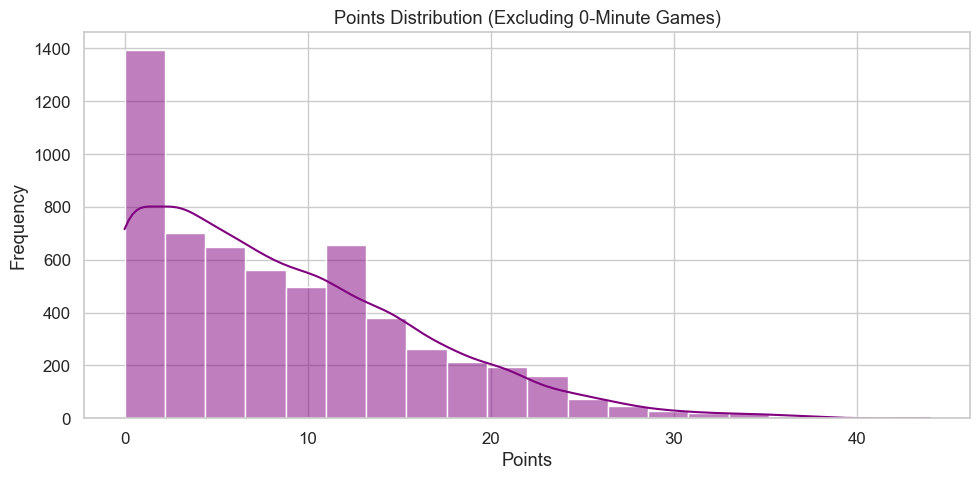

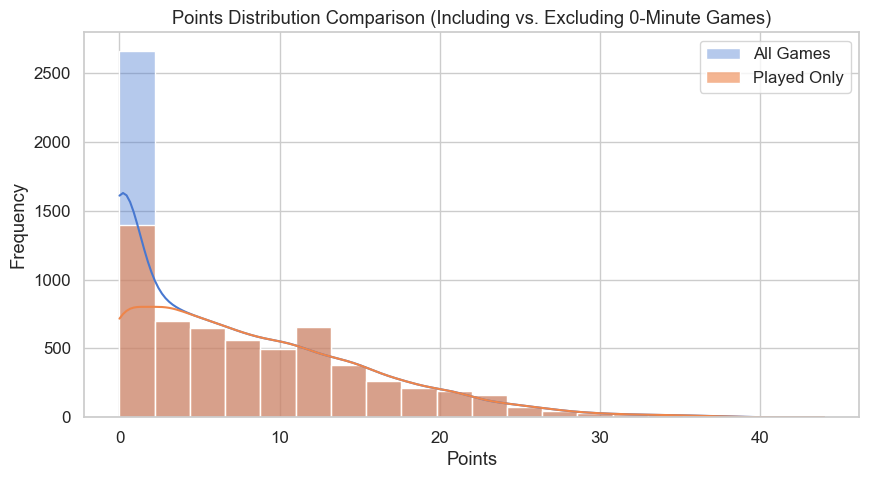

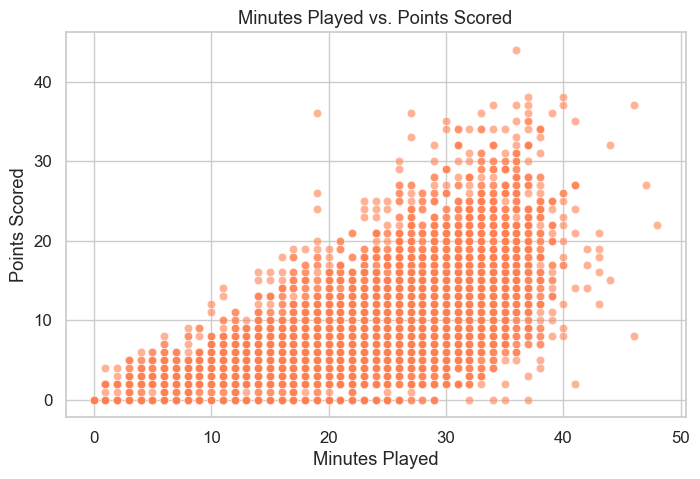

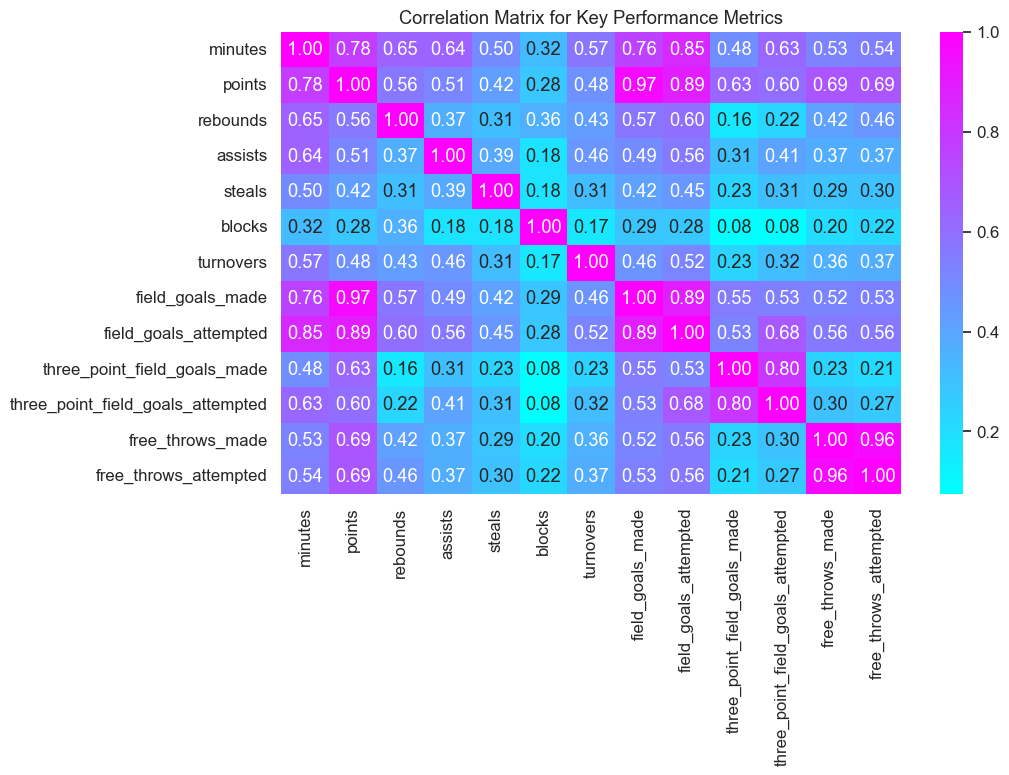

In [15]:
# =========================================
# 4. Exploratory Data Analysis (EDA)
# =========================================

# Summary statistics
df.describe()

# --- Percentage of 0-Minute Games ---
zero_minutes = df[df['minutes'] == 0].shape[0]
total_games = df.shape[0]

percentage_zero_minutes = (zero_minutes / total_games) * 100

print(f"Number of games with 0 minutes: {zero_minutes}")
print(f"Percentage of games with 0 minutes: {percentage_zero_minutes:.2f}%")


# --- Create filtered dataset (players who actually played) ---
df_played = df[df['minutes'] > 0]



# --- Distribution Plots ---
plt.figure(figsize=(18,5))

# 1. Points distribution (all games)
plt.figure(figsize=(10,5))
sns.histplot(df['points'], bins=20, kde=True, color="purple")
plt.title("Points Distribution (All Games)")
plt.xlabel("Points")
plt.ylabel("Frequency")

# 2. Points distribution (excluding 0-minute games)
plt.figure(figsize=(10,5))
sns.histplot(df_played['points'], bins=20, kde=True, color="purple")
plt.title("Points Distribution (Excluding 0-Minute Games)")
plt.xlabel("Points")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# --- Comparison  ---
plt.figure(figsize=(10,5))

sns.histplot(df['points'], bins=20, kde=True, alpha=0.4, label="All Games")
sns.histplot(df_played['points'], bins=20, kde=True, alpha=0.6, label="Played Only")

plt.title("Points Distribution Comparison (Including vs. Excluding 0-Minute Games)")
plt.xlabel("Points")
plt.ylabel("Frequency")
plt.legend()

plt.show()


# --- Minutes vs. Points ---
sns.scatterplot(x='minutes', y='points', data=df, alpha=0.6, color="coral")
plt.title("Minutes Played vs. Points Scored")
plt.xlabel("Minutes Played")
plt.ylabel("Points Scored")
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(10,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="cool", fmt=".2f")
plt.title("Correlation Matrix for Key Performance Metrics")
plt.show()


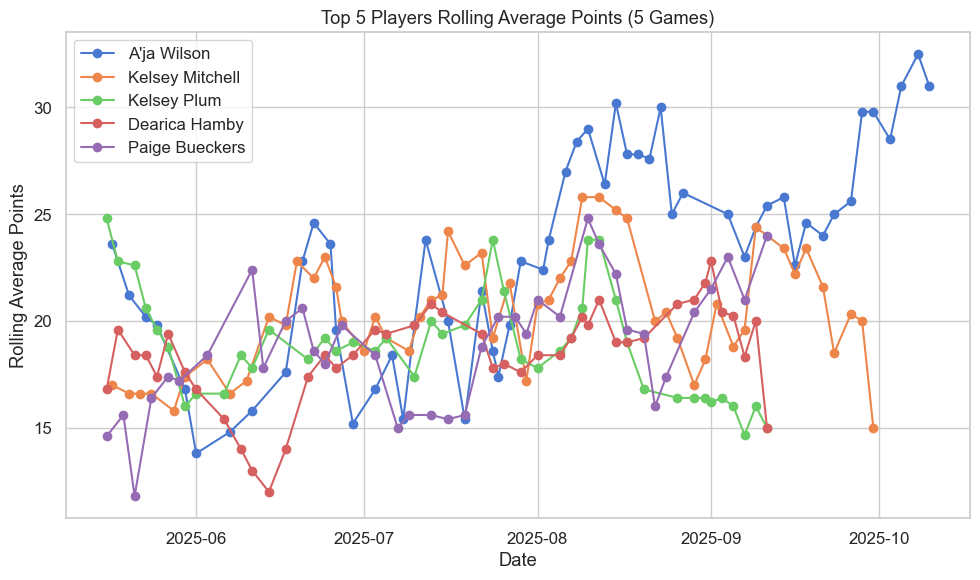

In [6]:
# -------------------------
# 3. Trend Analysis
# -------------------------
import matplotlib.pyplot as plt

# Calculate rolling average points per player (last 5 games)
df['points_rolling_avg'] = df.groupby('athlete_display_name')['points'] \
                             .transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Plot top 5 players by average points
top_players = df.groupby('athlete_display_name')['points'] \
                .mean().sort_values(ascending=False).head(5).index

plt.figure(figsize=(10,6))
for player in top_players:
    subset = df[df['athlete_display_name'] == player]
    plt.plot(subset['game_date'], subset['points_rolling_avg'], marker='o', label=player)

plt.title("Top 5 Players Rolling Average Points (5 Games)")
plt.xlabel("Date")
plt.ylabel("Rolling Average Points")
plt.legend()
plt.tight_layout()
plt.show()


Linear Regression R²: 0.7024136360354651
Linear Regression RMSE: 4.044529447543197
Random Forest R²: 0.7975724227052352
Random Forest RMSE: 3.3357717542989525


C:\Users\cruzm\AppData\Local\Temp\ipykernel_3948\1166527260.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=rf_importances, palette="viridis")


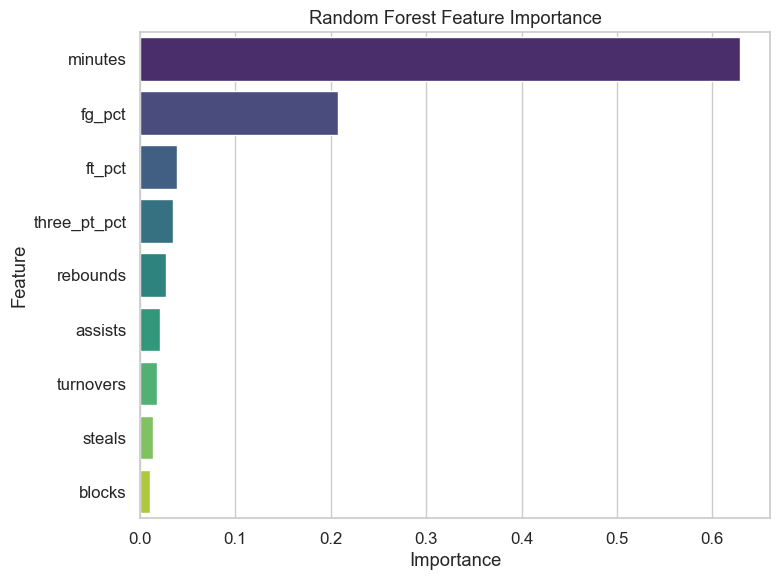

In [7]:
# -------------------------
# 4. Predictive Modeling
# -------------------------
# Features and target
X = df[[
    "minutes", "rebounds", "assists", "steals", "blocks",
    "turnovers", "fg_pct", "three_pt_pct", "ft_pct"
]].fillna(0)
y = df["points"].fillna(0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# --- Random Forest Regressor ---
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Feature importance
rf_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=rf_importances, palette="viridis")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()